<a href="https://colab.research.google.com/github/shivanivishwa/trader-sentiment-analysis/blob/main/trader-sentiment-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
# =========================
# 1. IMPORT LIBRARIES
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)


In [48]:
# =========================
# 2. LOAD DATA
# =========================
trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

print(trades.shape)
print(sentiment.shape)


(211224, 16)
(2644, 4)


In [49]:
# =========================
# 3. CLEAN COLUMN NAMES
# =========================
trades.columns = trades.columns.str.strip().str.lower().str.replace(" ", "_")
sentiment.columns = sentiment.columns.str.strip().str.lower()


In [50]:
# =========================
# 4. FIX TIMESTAMPS (CRITICAL)
# =========================
# Trader timestamps (DD-MM-YYYY format, IST)
trades["timestamp_ist"] = pd.to_datetime(
    trades["timestamp_ist"],
    dayfirst=True,
    errors="coerce"
)

# Create date column
trades["date"] = trades["timestamp_ist"].dt.date

# Drop rows with invalid dates (1 row only)
trades = trades.dropna(subset=["date"])

# Sentiment date
sentiment["date"] = pd.to_datetime(
    sentiment["date"],
    errors="coerce"
).dt.date

sentiment = sentiment.dropna(subset=["date"])


In [51]:
# =========================
# 5. FILTER VALID TRADES
# =========================
# Remove trades without realized PnL
trades = trades.dropna(subset=["closed_pnl"])

print(trades.shape)


(211224, 17)


In [52]:
# =========================
# 6. FEATURE ENGINEERING
# =========================
trades["is_profitable"] = trades["closed_pnl"] > 0
trades["roi"] = trades["closed_pnl"] / trades["size_usd"]

# Clean infinite values
trades.replace([np.inf, -np.inf], np.nan, inplace=True)
trades = trades.dropna(subset=["roi"])


In [53]:
# =========================
# 7. CHECK DATE OVERLAP
# =========================
common_dates = set(trades["date"]).intersection(set(sentiment["date"]))
print("Overlapping dates:", len(common_dates))


Overlapping dates: 479


In [54]:
# =========================
# 8. MERGE DATASETS
# =========================
df = trades.merge(
    sentiment[["date", "classification", "value"]],
    on="date",
    how="inner"
)

print(df.shape)
df.head()


(211175, 21)


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp,date,is_profitable,roi,classification,value
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,False,0.0,Extreme Greed,80
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,False,0.0,Extreme Greed,80
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,False,0.0,Extreme Greed,80
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,False,0.0,Extreme Greed,80
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,False,0.0,Extreme Greed,80


In [55]:
# =========================
# 9. SENTIMENT PERFORMANCE SUMMARY
# =========================
summary = df.groupby("classification").agg(
    trades=("closed_pnl", "count"),
    avg_pnl=("closed_pnl", "mean"),
    median_pnl=("closed_pnl", "median"),
    win_rate=("is_profitable", "mean"),
    avg_roi=("roi", "mean")
)

summary


,trades,avg_pnl,median_pnl,win_rate,avg_roi
classification,,,,,
Extreme Fear,21400,34.537862,0.0,0.370607,0.004321
Extreme Greed,39980,67.913239,0.0,0.465083,0.040027
Fear,61826,54.300059,0.0,0.420842,0.015412
Greed,50283,42.760561,0.0,0.384981,0.019653
Neutral,37686,34.307718,0.0,0.396991,0.009936


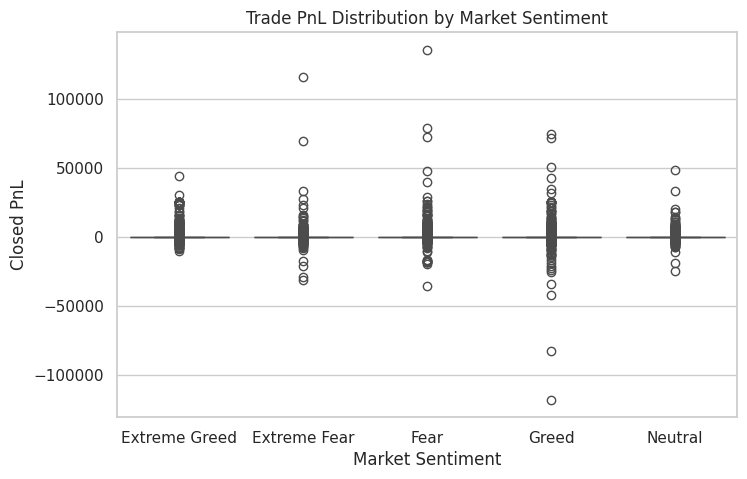

In [56]:
# =========================
# 10. VISUALIZATION: PnL vs SENTIMENT
# =========================
plt.figure(figsize=(8, 5))
sns.boxplot(x="classification", y="closed_pnl", data=df)
plt.title("Trade PnL Distribution by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Closed PnL")
plt.show()


In [57]:
# =========================
# 11. LOSS SEVERITY ANALYSIS
# =========================
loss_analysis = df[df["closed_pnl"] < 0].groupby("classification")["closed_pnl"].describe()
loss_analysis


,count,mean,std,min,25%,50%,75%,max
classification,,,,,,,,
Extreme Fear,2475.0,-257.099629,1187.655407,-31036.69194,-138.562509,-24.650581,-4.163619,-0.000078
Extreme Greed,2259.0,-119.920289,663.791423,-10259.46800,-24.367541,-4.245000,-0.814671,-0.000148
Fear,3789.0,-156.662401,1150.390464,-35681.74723,-46.240687,-8.867057,-1.412951,-0.000038
Greed,5818.0,-181.967329,2233.220127,-117990.10410,-32.904130,-10.756418,-2.142513,-0.000150
Neutral,3198.0,-121.727849,750.826865,-24500.00000,-36.388406,-8.760710,-1.815803,-0.000040


In [58]:
# =========================
# 12. TRADER-LEVEL BEHAVIOR (HIDDEN PATTERNS)
# =========================
trader_summary = df.groupby(
    ["account", "classification"]
).agg(
    trades=("closed_pnl", "count"),
    avg_pnl=("closed_pnl", "mean"),
    win_rate=("is_profitable", "mean"),
    avg_roi=("roi", "mean")
).reset_index()

trader_summary.head()


,account,classification,trades,avg_pnl,win_rate,avg_roi
0,0x083384f897ee0f19899168e3b1bec365f52a9012,Extreme Fear,100,1247.692214,0.370000,0.052553
1,0x083384f897ee0f19899168e3b1bec365f52a9012,Extreme Greed,945,-42.626810,0.066667,-0.001763
2,0x083384f897ee0f19899168e3b1bec365f52a9012,Fear,1778,626.194346,0.526434,0.053921
3,0x083384f897ee0f19899168e3b1bec365f52a9012,Greed,574,482.089321,0.160279,0.030677
4,0x083384f897ee0f19899168e3b1bec365f52a9012,Neutral,421,298.456334,0.581948,0.017256


In [59]:
# =========================
# 13. OPTIONAL: TOP TRADERS DURING FEAR
# =========================
top_fear_traders = trader_summary[
    trader_summary["classification"] == "Fear"
].sort_values(by="avg_roi", ascending=False).head(10)

top_fear_traders


,account,classification,trades,avg_pnl,win_rate,avg_roi
82,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,Fear,431,335.300103,0.645012,0.194774
42,0x420ab45e0bd8863569a5efbb9c05d91f40624641,Fear,98,1016.819167,0.357143,0.182764
97,0x8170715b3b381dffb7062c0298972d4727a0a63b,Fear,1745,86.700707,0.296848,0.094463
148,0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3,Fear,1181,200.506120,0.498730,0.082436
2,0x083384f897ee0f19899168e3b1bec365f52a9012,Fear,1778,626.194346,0.526434,0.053921
87,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,Fear,1664,29.666031,0.779447,0.030667
127,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,Fear,123,66.092200,0.349593,0.027904
52,0x47add9a56df66b524d5e2c1993a43cde53b6ed85,Fear,924,10.821953,0.376623,0.027751
57,0x4acb90e786d897ecffb614dc822eb231b4ffb9f4,Fear,1396,212.594357,0.409026,0.021723
37,0x3f9a0aadc7f04a7c9d75dc1b5a6ddd6e36486cf6,Fear,79,53.880498,0.620253,0.020733
